In [1]:
import mxnet
from mxnet import gluon
from mxnet import nd
from mxnet.gluon.model_zoo import vision
import Read_Data
import Net_Train

### 常用变量定义

In [9]:
Path_Image = '../../../Data/train_1/'
Path_Label = '../../../Data/'
File_Name = 'Train_CIFAR10.csv'
Label_Name = 'trainLabels_1.csv'
Batch_size = 256
Size = 224

### 通过GPU训练数据

In [10]:
def try_gpu():
    """If GPU is available, return mx.gpu(0); else return mx.cpu()"""
    try:
        ctx = mxnet.gpu()
        _ = nd.array([0], ctx=ctx)
    except:
        ctx = mxnet.cpu()
    return ctx
ctx = try_gpu()
#ctx = mxnet.cpu()
print(ctx)

gpu(0)


## 创建深度网络

In [11]:
from mxnet import gluon
from mxnet import init
from mxnet.gluon import nn
ConvNet = nn.Sequential()
with ConvNet.name_scope():
    ConvNet.add(
        nn.Conv2D(channels=20, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=50, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(128, activation="relu"),
        nn.Dense(10)
    )
ConvNet.initialize(init=init.Xavier(), ctx=ctx)

In [12]:
AlexNet = vision.AlexNet(classes=10)
AlexNet.initialize(init=init.Xavier(), ctx = ctx)


#print(AlexNet)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
Trainer = gluon.Trainer(AlexNet.collect_params(), 'sgd', {'learning_rate': 0.5})

## 读取训练
通过读取数据的时间与直接处理的时间相对比，可以发现，数据不需要储存成csv，这样既能节省时间又能节省空间

In [13]:
from time import clock
start = clock()
# 分析解读数据！！！
Data = Read_Data.MixImageAndLabel(Path_Image, Path_Label,Label_Name)
print(Data.shape)
end = clock()
time = end - start;
print("proprocess time is %f" % (time))
# start = clock()
# # 保存数据！！！
# Read_Data.SaveData2CSV(Data, File_Name, Path_Label)
# end = clock()
# time = end - start;
# print("Save Finished! time is %f" % (time))

(2560, 3073)
proprocess time is 0.292679


/home/ubuntu/Yongchao/yongchao/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
# # 读取数据
# start = clock()
# Data = Net_Train.ReadData(File_Name, Path_Label)
# end = clock()
# time = end - start;
# print("Read Data! time is %f" % (time))
# print(Data.shape)

### 对数据进行分类与预处理

2048 512


/home/ubuntu/Yongchao/Computer_Vision/Kaggle/CIFAR-10/Net_Train.py:49: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  Image.append(misc.imresize(Data[i,1:].reshape(3, 32, 32), (resize,resize)).flatten())
/home/ubuntu/Yongchao/yongchao/lib/python3.6/site-packages/scipy/misc/pilutil.py:554: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  im = toimage(arr, mode=mode)
/home/ubuntu/Yongchao/yongchao/lib/python3.6/site-packages/scipy/misc/pilutil.py:380: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
/home/ubuntu/Yongchao/yongchao/lib/python3.6/site-packages/scipy/misc/pilutil.py:565: DeprecationWarning: `fromimage` is de

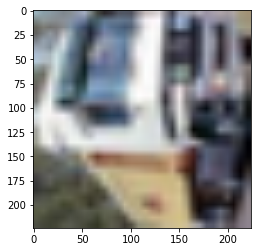

(8, 256, 150529)
(512, 150529)


In [15]:
Train_data, Test_data = Net_Train.loadTrainTestData(Data, Batch_size, resize=Size)
print(Train_data.shape)
print(Test_data.shape)

In [16]:
Net_Train.train(Train_data, Test_data, AlexNet, 5, loss, Trainer, size=Size, ctx=ctx)

Echoe is 1, Train Loss is 2.308019, Train Acc is 0.107422, Test Acc is 0.091797, Use-time is 2.797373 S
Echoe is 2, Train Loss is 2.304209, Train Acc is 0.105957, Test Acc is 0.101562, Use-time is 1.966853 S
Echoe is 3, Train Loss is 2.303899, Train Acc is 0.095215, Test Acc is 0.101562, Use-time is 2.128847 S
Echoe is 4, Train Loss is 2.303698, Train Acc is 0.099609, Test Acc is 0.101562, Use-time is 2.102661 S
Echoe is 5, Train Loss is 2.302721, Train Acc is 0.103027, Test Acc is 0.101562, Use-time is 1.934296 S


# 在调试过程中存在的几个问题！
1. 由于数据量过大，直接放入内存或者GPU会导致Memroy不足的提示
2. 利用自己的train函数，训练输出的结果近似等于没有训练

方法：
1. 数据部分训练的原则，每次都取部分数据进行分析，分析完后及时释放
2. 利用MNIST的数据，对自己编写的train函数进行进一步的测试！